# **ADULT CENSUS INCOME PREDICTION**

In [1]:
!pip install scikit-plot
!pip install -U seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import scikitplot as skplt


In [4]:
dataset=pd.read_csv("adult.csv")

In [5]:
print(dataset.isnull().sum())
print(dataset.dtypes)

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64
age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object


In [6]:
dataset.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [7]:
#removing '?' containing rows
dataset = dataset[(dataset != '?').all(axis=1)]
#label the income objects as 0 and 1
dataset['income']=dataset['income'].map({'<=50K': 0, '>50K': 1})

<ipython-input-7-39ed73805135>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['income']=dataset['income'].map({'<=50K': 0, '>50K': 1})


## Analyze data

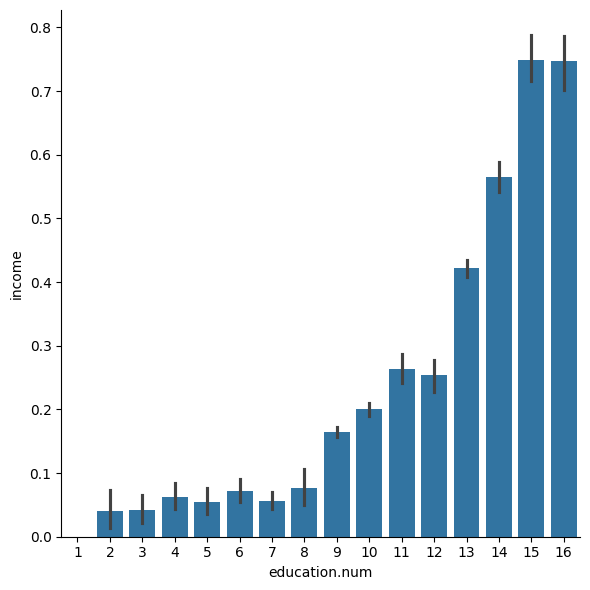

In [8]:
sns.catplot(x='education.num',y='income',data=dataset,kind='bar',height=6)
plt.show()

Higher the value ,higher the probability of income greater than 50k(Obviously!)

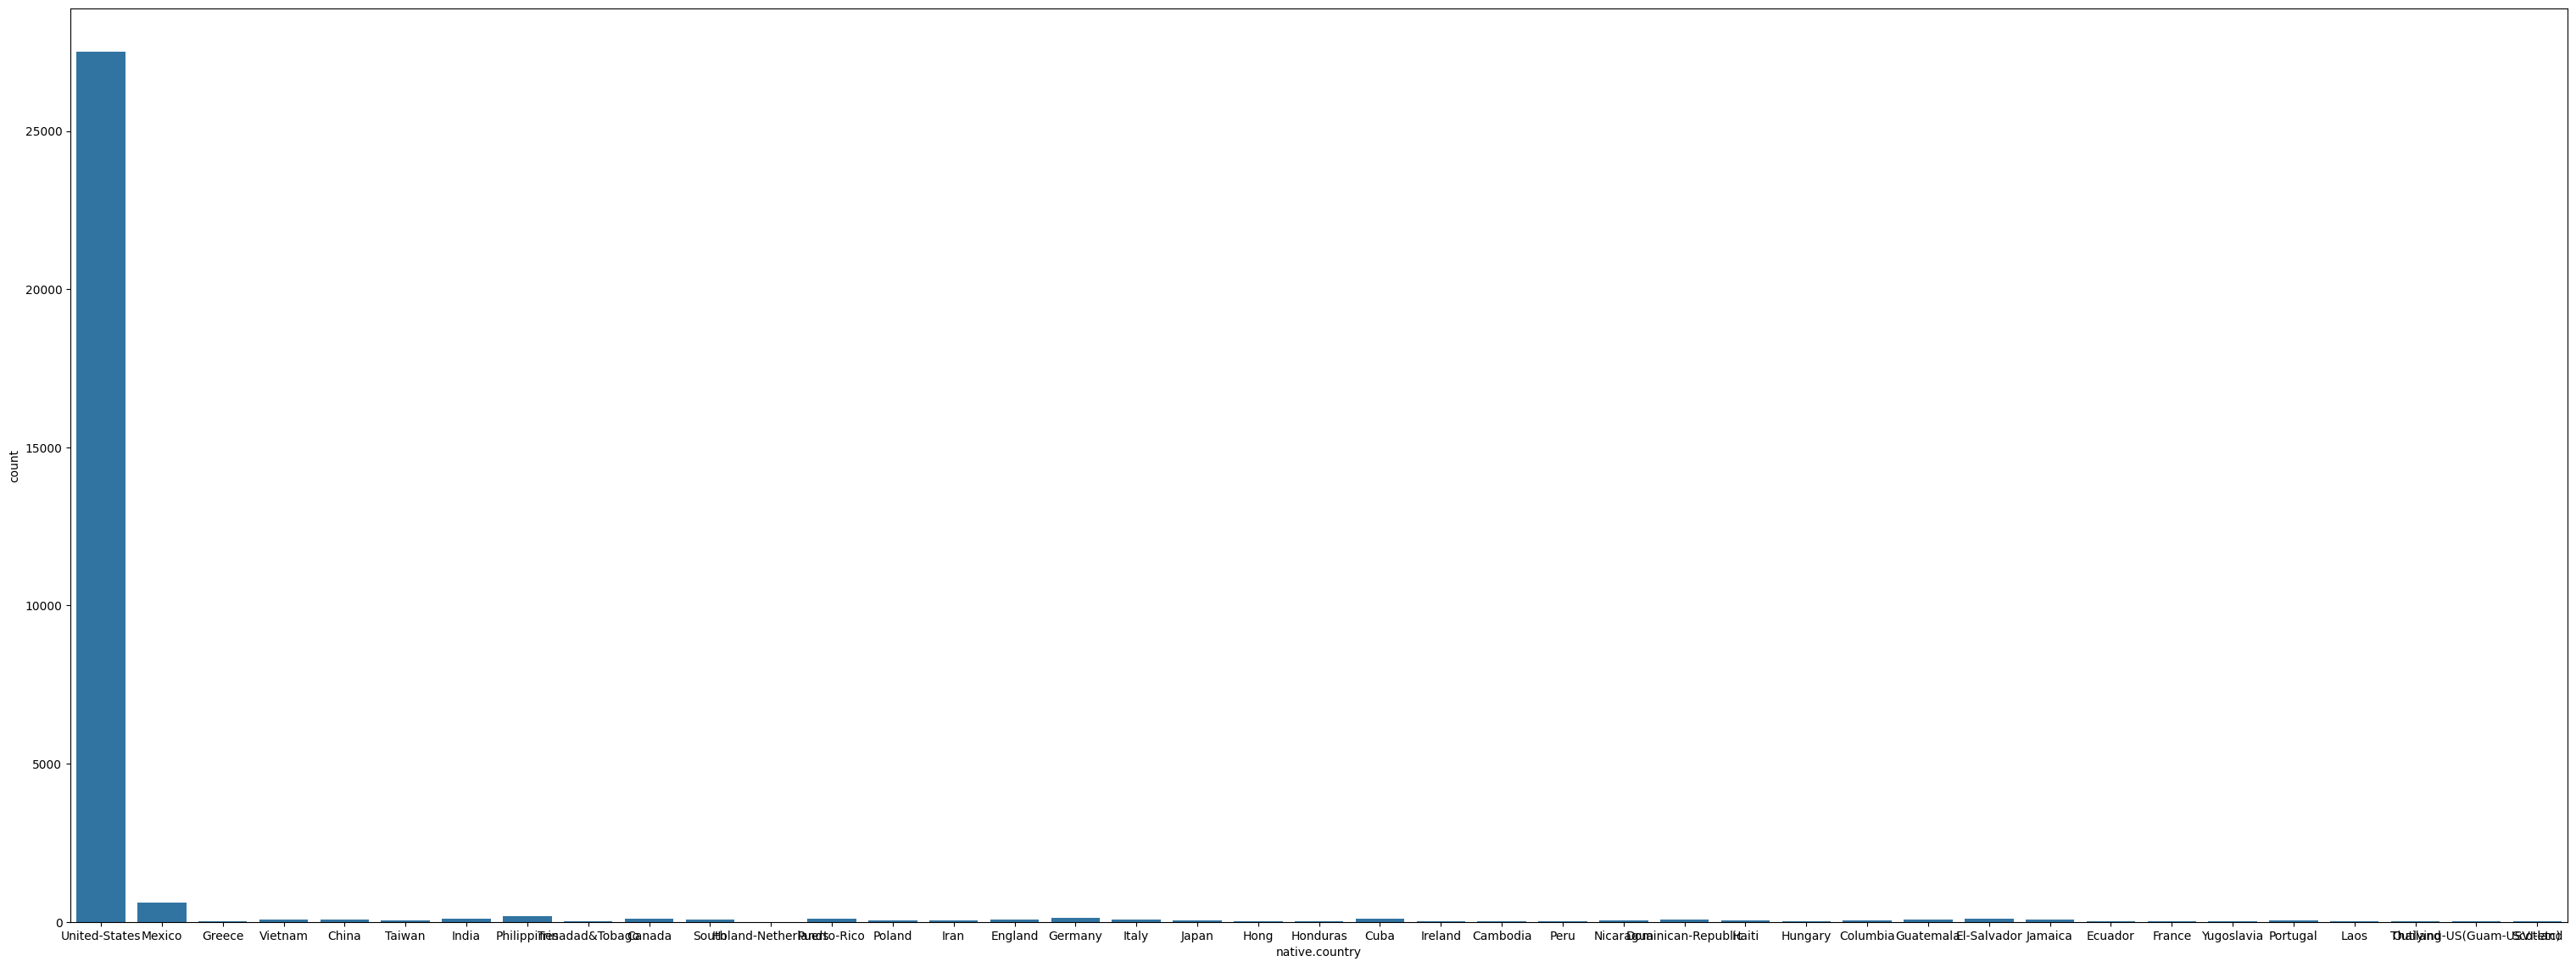

In [9]:
#explore which country do most people belong
plt.figure(figsize=(38,14))
sns.countplot(x='native.country',data=dataset)
plt.show()

Here most people are from the USA,so we can drop this column as it creates unnecessary bias.

## Feature Engineering

In [10]:
#we can reformat marital.status values to single and married
dataset['marital.status']=dataset['marital.status'].map({'Married-civ-spouse':'Married', 'Divorced':'Single', 'Never-married':'Single', 'Separated':'Single',
'Widowed':'Single', 'Married-spouse-absent':'Married', 'Married-AF-spouse':'Married'})

 ### *Label encoding*

In [11]:
for column in dataset:
    enc=LabelEncoder()
    if dataset.dtypes[column]==np.object:
         dataset[column]=enc.fit_transform(dataset[column])

<ipython-input-11-5d7d7fe4d7c0>:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dataset.dtypes[column]==np.object:
<ipython-input-11-5d7d7fe4d7c0>:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dataset.dtypes[column]==np.object:
<ipython-input-11-5d7d7fe4d7c0>:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.

### *Correlation using heatmap*

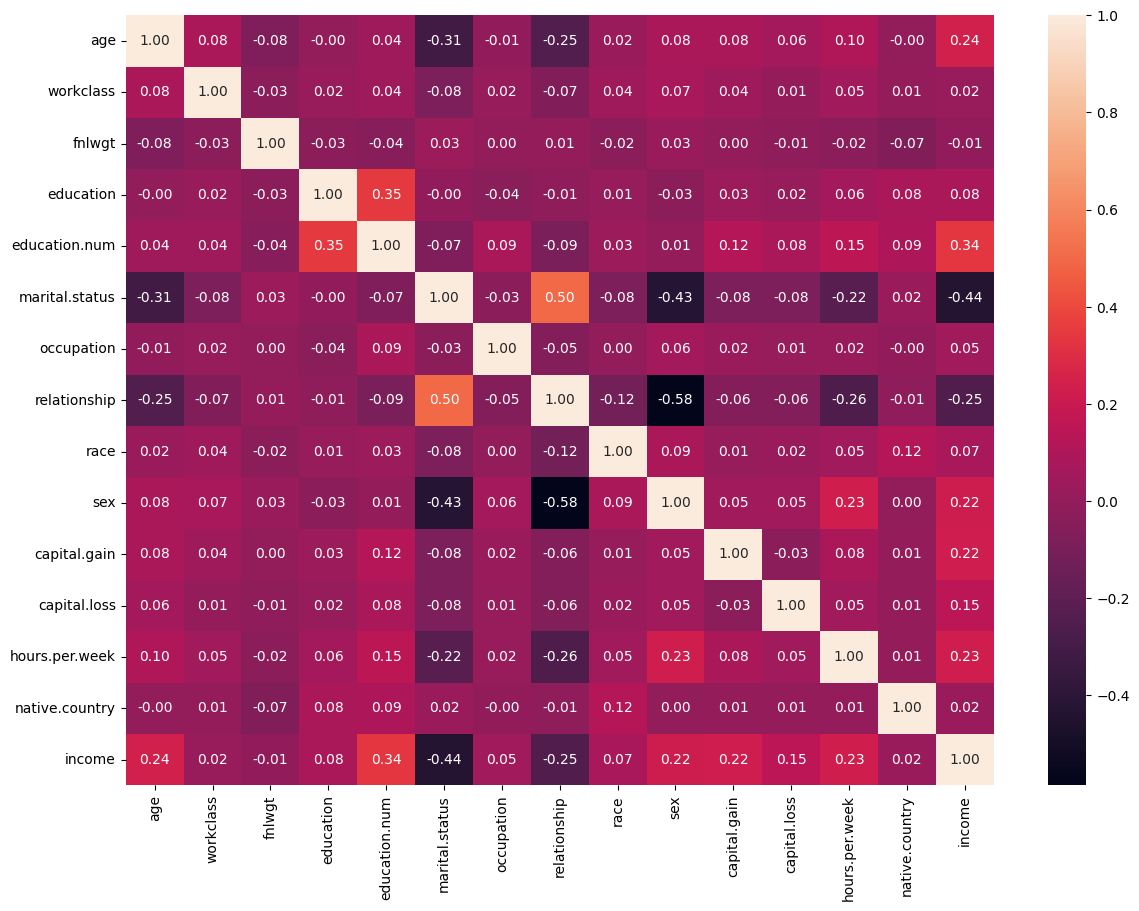

In [12]:
plt.figure(figsize=(14,10))
sns.heatmap(dataset.corr(),annot=True,fmt='.2f')
plt.show()

In [13]:
dataset=dataset.drop(['relationship','education'],axis=1)

In [14]:
dataset=dataset.drop(['occupation','fnlwgt','native.country'],axis=1)

 Dataset after preprocessing

In [15]:
print(dataset.head())

   age  workclass  education.num  marital.status  race  sex  capital.gain  \
1   82          2              9               1     4    0             0   
3   54          2              4               1     4    0             0   
4   41          2             10               1     4    0             0   
5   34          2              9               1     4    0             0   
6   38          2              6               1     4    1             0   

   capital.loss  hours.per.week  income  
1          4356              18       0  
3          3900              40       0  
4          3900              40       0  
5          3770              45       0  
6          3770              40       0  


Split the dataset into predictors and target and make training and testing sets

In [16]:
X=dataset.iloc[:,0:-1]
y=dataset.iloc[:,-1]
print(X.head())
print(y.head())
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.33,shuffle=False)

   age  workclass  education.num  marital.status  race  sex  capital.gain  \
1   82          2              9               1     4    0             0   
3   54          2              4               1     4    0             0   
4   41          2             10               1     4    0             0   
5   34          2              9               1     4    0             0   
6   38          2              6               1     4    1             0   

   capital.loss  hours.per.week  
1          4356              18  
3          3900              40  
4          3900              40  
5          3770              45  
6          3770              40  
1    0
3    0
4    0
5    0
6    0
Name: income, dtype: int64


In [17]:
clf=GaussianNB()
cv_res=cross_val_score(clf,x_train,y_train,cv=10)
print(cv_res.mean()*100)

76.68213951528749


In [18]:
clf=DecisionTreeClassifier()
cv_res=cross_val_score(clf,x_train,y_train,cv=10)
print(cv_res.mean()*100)

74.20353368835151


In [19]:
clf=RandomForestClassifier(n_estimators=100)
cv_res=cross_val_score(clf,x_train,y_train,cv=10)
print(cv_res.mean()*100)

76.65793573419688


### *Fit the model with tuned parameters*

In [20]:
clf=RandomForestClassifier(n_estimators=50,max_features=5,min_samples_leaf=50)
clf.fit(x_train,y_train)

RandomForestClassifier(max_features=5, min_samples_leaf=50, n_estimators=50)

In [21]:
pred=clf.predict(x_test)
pred

array([1, 1, 1, ..., 0, 0, 0])

In [22]:
print("Accuracy: %f " % (100*accuracy_score(y_test, pred)))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

Accuracy: 84.589110 
[[7520  422]
 [1112  900]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7942
           1       0.68      0.45      0.54      2012

    accuracy                           0.85      9954
   macro avg       0.78      0.70      0.72      9954
weighted avg       0.83      0.85      0.83      9954

